In [53]:
from utils import get_dataframe
from nltk.tokenize import word_tokenize, sent_tokenize

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

In [54]:
df = get_dataframe()
df

,question,human_answers,chatgpt_answers
0,Historical P/E ratios of small-cap vs. large-c...,[There is most likely an error in the WSJ's da...,[Historical price-to-earnings (P/E) ratios for...
1,Should you co-sign a personal loan for a frien...,[I know this question has a lot of answers alr...,[Co-signing a personal loan for a friend or fa...
2,Should I avoid credit card use to improve our ...,[If you pay it off before the cycle closes it ...,[It can be a good idea to avoid using credit c...
3,Difference between 'split and redemption' of s...,[It is the first time I encounter redemption p...,[Share split and redemption are two different ...
4,Pros & cons of investing in gold vs. platinum?,[Why Investors Buy Platinum is an old (1995) a...,[Gold and platinum are both precious metals th...
...,...,...,...
837,"Please explain what is ""Punched cards""",[A punched card (also punch card or punched-ca...,[Punched cards were a means of storing and pro...
838,"Please explain what is ""Paper tape""",[Punched tape or perforated paper tape is a fo...,[Paper tape is a medium for storing and transm...
839,"Please explain what is ""BBC Model B""",[The British Broadcasting Corporation Microcom...,[The BBC Model B is a computer that was made b...
840,"Please explain what is ""O level""",[The O-Level (Ordinary Level) is a subject-bas...,"[""O level"" refers to the General Certificate o..."


In [55]:
df["len_human_answer"] = df.human_answers.apply(lambda x : len(x))

In [56]:
df["len_human_answer"][df["len_human_answer"] > 1]

Series([], Name: len_human_answer, dtype: int64)

In [57]:
df["len_ai_answer"] = df.chatgpt_answers.apply(lambda x : len(x))

In [58]:
df[df["len_ai_answer"] == 3].chatgpt_answers[0]

['Sound mass is a term used to describe a type of texture in music that is characterized by a dense, homogenous sound created by the layering and combining of multiple voices or instruments. There are many composers who have used sound mass techniques in their compositions, including:\\n\\nPierre Boulez: Boulez was a French composer and conductor who was known for his use of sound mass techniques in his compositions. He often used these techniques to create a sense of density and complexity in his music.\\n\\nGyörgy Ligeti: Ligeti was a Hungarian-Austrian composer who was known for his use of sound mass techniques in his music. His compositions often featured complex, layered textures that were created by the layering and combining of multiple voices or instruments.\\n\\nKarlheinz Stockhausen: Stockhausen was a German composer who was known for his innovative use of sound mass techniques in his music. He often used these techniques to create a sense of density and complexity in his com

In [59]:
df.columns

Index(['question', 'human_answers', 'chatgpt_answers', 'len_human_answer',
       'len_ai_answer'],
      dtype='object')

In [60]:
df.human_answers = df.human_answers.apply(lambda x : x[0])

In [61]:
df

,question,human_answers,chatgpt_answers,len_human_answer,len_ai_answer
0,Historical P/E ratios of small-cap vs. large-c...,There is most likely an error in the WSJ's dat...,[Historical price-to-earnings (P/E) ratios for...,1,1
1,Should you co-sign a personal loan for a frien...,I know this question has a lot of answers alre...,[Co-signing a personal loan for a friend or fa...,1,1
2,Should I avoid credit card use to improve our ...,If you pay it off before the cycle closes it w...,[It can be a good idea to avoid using credit c...,1,1
3,Difference between 'split and redemption' of s...,It is the first time I encounter redemption pr...,[Share split and redemption are two different ...,1,1
4,Pros & cons of investing in gold vs. platinum?,Why Investors Buy Platinum is an old (1995) ar...,[Gold and platinum are both precious metals th...,1,1
...,...,...,...,...,...
837,"Please explain what is ""Punched cards""",A punched card (also punch card or punched-car...,[Punched cards were a means of storing and pro...,1,1
838,"Please explain what is ""Paper tape""",Punched tape or perforated paper tape is a for...,[Paper tape is a medium for storing and transm...,1,1
839,"Please explain what is ""BBC Model B""",The British Broadcasting Corporation Microcomp...,[The BBC Model B is a computer that was made b...,1,1
840,"Please explain what is ""O level""",The O-Level (Ordinary Level) is a subject-base...,"[""O level"" refers to the General Certificate o...",1,1


In [62]:
df.chatgpt_answers = df.chatgpt_answers.apply(lambda x : x[0])

In [63]:
df

,question,human_answers,chatgpt_answers,len_human_answer,len_ai_answer
0,Historical P/E ratios of small-cap vs. large-c...,There is most likely an error in the WSJ's dat...,Historical price-to-earnings (P/E) ratios for ...,1,1
1,Should you co-sign a personal loan for a frien...,I know this question has a lot of answers alre...,Co-signing a personal loan for a friend or fam...,1,1
2,Should I avoid credit card use to improve our ...,If you pay it off before the cycle closes it w...,It can be a good idea to avoid using credit ca...,1,1
3,Difference between 'split and redemption' of s...,It is the first time I encounter redemption pr...,Share split and redemption are two different c...,1,1
4,Pros & cons of investing in gold vs. platinum?,Why Investors Buy Platinum is an old (1995) ar...,Gold and platinum are both precious metals tha...,1,1
...,...,...,...,...,...
837,"Please explain what is ""Punched cards""",A punched card (also punch card or punched-car...,Punched cards were a means of storing and proc...,1,1
838,"Please explain what is ""Paper tape""",Punched tape or perforated paper tape is a for...,Paper tape is a medium for storing and transmi...,1,1
839,"Please explain what is ""BBC Model B""",The British Broadcasting Corporation Microcomp...,The BBC Model B is a computer that was made by...,1,1
840,"Please explain what is ""O level""",The O-Level (Ordinary Level) is a subject-base...,"""O level"" refers to the General Certificate of...",1,1


In [64]:
df = df.drop(columns=['len_human_answer', 'len_ai_answer'])

In [65]:
df.iloc[1000]


question               Should I pay off investment property mortgage
human_answers      I would not recommend using your own money to ...
chatgpt_answers    There are a few factors to consider when decid...
Name: 1000, dtype: object

In [66]:
def lemma_tokenize(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(doc)]

def char_tokenize(doc):
    return [char for char in doc]

def byte_tokenize(doc):
    tokens = doc.encode("utf-8")
    tokens = list(map(int, tokens))
    return [str(token) for token in tokens]

def gpt_tokenize(doc):
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

In [67]:
df_1 = df.copy(deep=True)
df_2 = df.copy(deep=True)

In [68]:
df_1["target"] = 1
df_1 = df_1.drop(columns=['human_answers'])
df_1.rename(columns={"chatgpt_answers": "answers"}, inplace=True)

df_2["target"] = 0
df_2 = df_2.drop(columns=['chatgpt_answers'])
df_2.rename(columns={"human_answers": "answers"}, inplace=True)

In [69]:
df_model = pd.concat([df_1, df_2])
df_model

,question,answers,target
0,Historical P/E ratios of small-cap vs. large-c...,Historical price-to-earnings (P/E) ratios for ...,1
1,Should you co-sign a personal loan for a frien...,Co-signing a personal loan for a friend or fam...,1
2,Should I avoid credit card use to improve our ...,It can be a good idea to avoid using credit ca...,1
3,Difference between 'split and redemption' of s...,Share split and redemption are two different c...,1
4,Pros & cons of investing in gold vs. platinum?,Gold and platinum are both precious metals tha...,1
...,...,...,...
837,"Please explain what is ""Punched cards""",A punched card (also punch card or punched-car...,0
838,"Please explain what is ""Paper tape""",Punched tape or perforated paper tape is a for...,0
839,"Please explain what is ""BBC Model B""",The British Broadcasting Corporation Microcomp...,0
840,"Please explain what is ""O level""",The O-Level (Ordinary Level) is a subject-base...,0


In [70]:
# shuffling

df_model = df_model.sample(frac=1).reset_index(drop=True)
df_model

,question,answers,target
0,Can rapid heart rate cause damage to heart?my ...,"Rapid heart rate, or tachycardia, can potentia...",1
1,How important is reconciling accounts for a sm...,I would suggest opening a new account (credit ...,0
2,Is it better to buy a computer on my credit ca...,There are a few factors to consider when decid...,1
3,Tracking down forgotten brokerage account,If you think you may have forgotten about a br...,1
4,Higher auto insurance costs: keep car or switc...,I'm guessing Toronto? Sell the car! Use public...,0
...,...,...,...
14415,"Please explain what is ""Vulnerability (computi...",Vulnerabilities are flaws in a computer system...,0
14416,How do banks lose money on foreclosures?,Someone has to hand out cash to the seller. Ev...,0
14417,how many users do twitter have,"As of 2021, Twitter had over 330 million month...",1
14418,what part of the pre-world war 1 arms race was...,The pre-World War I arms race was characterize...,1


In [71]:
X_train, X_test, y_train, y_test = train_test_split(df_model["answers"], df_model["target"], test_size=0.2, random_state=69)

X_val, X_test, y_val, y_test  = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [72]:
model = make_pipeline(CountVectorizer(tokenizer=gpt_tokenize, lowercase=True), LogisticRegression(random_state=69, penalty = 'l2'))

In [73]:
model.fit(X_train, y_train)

/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(tokenizer=<function gpt_tokenize at 0x7f5e818e4ae0>)),
                ('logisticregression', LogisticRegression(random_state=69))])

In [74]:
# Predict using the test set
y_pred_test = model.predict(X_test)
print("Test Set Classification Report:\n", classification_report(y_test, y_pred_test))

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       741
           1       0.99      0.98      0.98       701

    accuracy                           0.98      1442
   macro avg       0.98      0.98      0.98      1442
weighted avg       0.98      0.98      0.98      1442



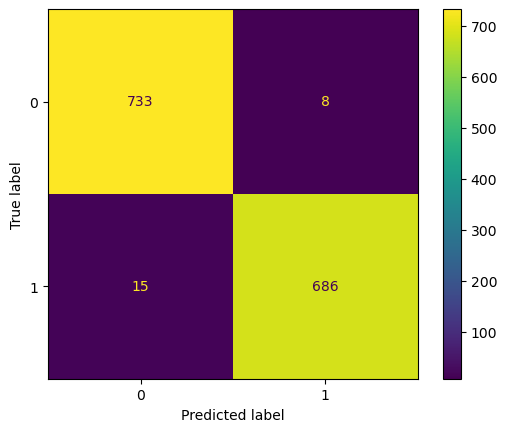

In [75]:
cm = confusion_matrix(y_test, y_pred_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

In [76]:
# Predict using the validation set
y_pred_val = model.predict(X_val)
print("Validation Set Classification Report:\n", classification_report(y_val, y_pred_val))

Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       745
           1       0.98      0.98      0.98       697

    accuracy                           0.98      1442
   macro avg       0.98      0.98      0.98      1442
weighted avg       0.98      0.98      0.98      1442



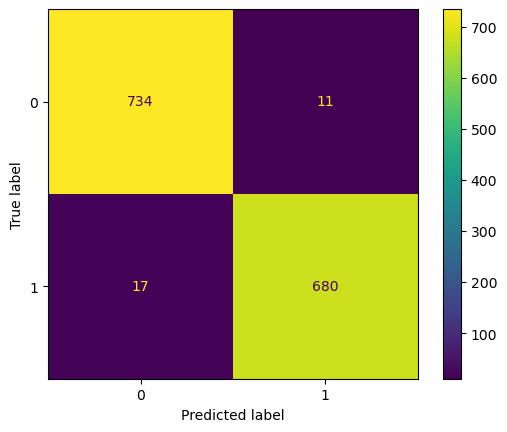

In [77]:
cm = confusion_matrix(y_val, y_pred_val, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

In [78]:
model.predict(["Hello I am stupid"])

array([0])